In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import math
import sys
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import writer, SummaryWriter
from torch.utils.data import DataLoader
from math import pi

from torch import nn
from torch.nn.utils import spectral_norm

## Data

The historical data has been downloaded from https://finance.yahoo.com/ 

In [2]:
data = pd.read_csv('./data/SPY.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.370279,480500
1,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.426161,201300
2,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.705482,529400
3,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.817228,531500
4,1993-02-05,44.96875,45.06250,44.71875,44.96875,26.798601,492100


Text(0.5, 0, 'Date')

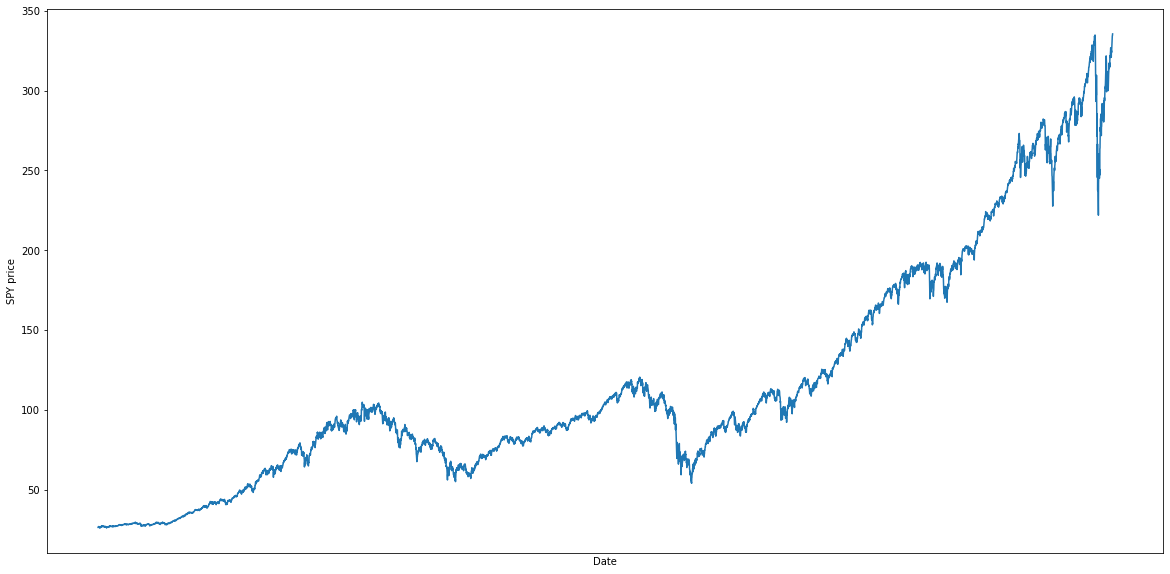

In [3]:
plt.figure(figsize=(20,10))
plt.plot(data['Date'],data['Adj Close'])
# plt.xticks(data['Adj Close'][::50])
plt.xticks([])  # Disable xticks.
plt.ylabel('SPY price')
plt.xlabel('Date')

In [4]:
data.shift(periods=1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,26.370279,480500.0
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,26.426161,201300.0
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,26.705482,529400.0
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.817228,531500.0
...,...,...,...,...,...,...,...
6927,2020-08-03,328.320007,329.619995,327.730011,328.790009,328.790009,53077900.0
6928,2020-08-04,327.859985,330.059998,327.859985,330.059998,330.059998,41917900.0
6929,2020-08-05,331.470001,332.390015,331.179993,332.109985,332.109985,42866400.0
6930,2020-08-06,331.480011,334.459991,331.130005,334.329987,334.329987,43679400.0


In [5]:
data['returns'] = (data['Adj Close'] - data.shift(periods=1)['Adj Close']) / data['Adj Close']

In [6]:
data = data.iloc[1:]
data['returns'][:5]

1    0.002115
2    0.010459
3    0.004167
4   -0.000695
5    0.000000
Name: returns, dtype: float64

Text(0.5, 0, 'Date')

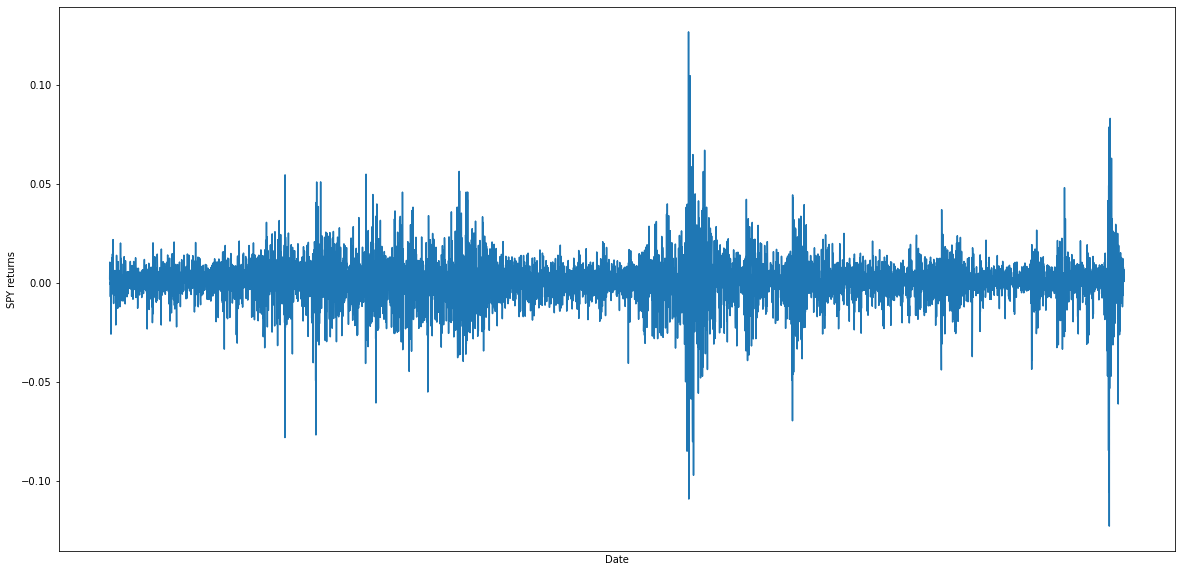

In [7]:
plt.figure(figsize=(20,10))
plt.plot(data['Date'], data['returns'])
# plt.xticks(data['Adj Close'][::50])
plt.xticks([])  # Disable xticks.
plt.ylabel('SPY returns')
plt.xlabel('Date')

In [8]:
from torch.utils.data import Dataset, DataLoader

class Returns(Dataset):
    def __init__(self, data_frame, window_size):
        self.data = data_frame.values
        self.window_size = window_size
        self.dataset = self._generate_dataset()

    def __len__(self):
        return self.data.shape[0] // self.window_size

    def __getitem__(self, index):
        return self.dataset[index]

    def _generate_dataset(self):
        dataset = []
        # return self.data[index * self.window_size: (index+1) * self.window_size]
        for i in range(2 * self.__len__() - 1):
            sample = self.data[int(i * self.window_size / 2): int(i * self.window_size / 2) + self.window_size]
#             print(sample.shape)
#             print(np.squeeze(sample).shape)
            sample = np.squeeze(sample)
            dataset.append(sample)

        return np.array(dataset)

In [43]:
dataset = Returns(data[['returns']], 100)

In [44]:
dataset.__getitem__(-1).shape

(100,)

In [11]:
data['returns'][-5:]

6927    0.003848
6928    0.006173
6929    0.006640
6930    0.000717
6931    0.002980
Name: returns, dtype: float64

In [24]:
from typing import Sequence

from torch.utils.data import Dataset
import numpy as np


class Sines(Dataset):

    def __init__(self, frequency_range: Sequence[float], amplitude_range: Sequence[float],
                 n_series: int = 200, datapoints: int = 100, seed: int = None):
        """
        Pytorch Dataset to produce sines.
        y = A * sin(B * x)
        :param frequency_range: range of A
        :param amplitude_range: range of B
        :param n_series: number of sines in your dataset
        :param datapoints: length of each sample
        :param seed: random seed
        """
        self.n_series = n_series
        self.datapoints = datapoints
        self.seed = seed
        self.frequency_range = frequency_range
        self.amplitude_range = amplitude_range
        self.dataset = self._generate_sines()

    def __len__(self):
        return self.n_series

    def __getitem__(self, idx):
        return self.dataset[idx]

    def _generate_sines(self):
        if self.seed is not None:
            np.random.seed(self.seed)

        x = np.linspace(start=0, stop=2 * np.pi, num=self.datapoints)
        low_freq, up_freq = self.frequency_range[0], self.frequency_range[1]
        low_amp, up_amp = self.amplitude_range[0], self.amplitude_range[1]

        freq_vector = (up_freq - low_freq) * np.random.rand(self.n_series, 1) + low_freq
        ampl_vector = (up_amp - low_amp) * np.random.rand(self.n_series, 1) + low_amp

        return ampl_vector * np.sin(freq_vector * x)

In [25]:
dataset = Sines(frequency_range=[0, 2 * pi], amplitude_range=[0, 2 * pi], seed=42, n_series=200)
# dataloader = DataLoader(dataset, batch_size=args.batches)

In [28]:
dataset.__getitem__(0).shape

(100,)

## GAN

In [9]:
class ExpandDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)

class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = self.create_architecture()

    def forward(self, input):
        return self.main(input)
    
    def create_architecture(self):
        return nn.Sequential(nn.Linear(50, 100),
                     nn.LeakyReLU(0.2, inplace=True),
                     AddDimension(),
                     spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                     nn.Upsample(200),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Upsample(400),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Upsample(800),

                     spectral_norm(nn.Conv1d(32, 1, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),

                     SqueezeDimension(),
                     nn.Linear(800, 100)
                     )

In [25]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(in_feat, n_filters, kernel_size, padding, upsample_size):
            layers = []
            layers.append(nn.Conv1d(in_feat, n_filters, kernel_size, padding=padding))
            layers.append(nn.BatchNorm1d(n_filters, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Upsample(upsample_size))
            return layers
        
        self.model = nn.Sequential(
            nn.Linear(50, 100),
            nn.BatchNorm1d(100, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            ExpandDimension(),
            *block(1, n_filters=32, kernel_size=3, padding=1, upsample_size=200),
            *block(32, n_filters=32, kernel_size=3, padding=1, upsample_size=400),
            *block(32, n_filters=32, kernel_size=3, padding=1, upsample_size=800),
            nn.Conv1d(32, 1, 3, padding=1),
            nn.BatchNorm1d(1, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            SqueezeDimension(),
            nn.Linear(800, 100),
            nn.BatchNorm1d(100, 0.8),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

In [26]:
g = Generator()

In [35]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = self.create_architecture()

    def forward(self, input):
        return self.main(input)
    
    def create_architecture(self):
        return nn.Sequential(AddDimension(),
                     spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.MaxPool1d(2),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.MaxPool1d(2),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Flatten(),

                     nn.Linear(800, 50),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Linear(50, 15),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Linear(15, 1)
                     )

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
#         self.model = self.build_model()
        def block(in_feat, n_filters, kernel_size, padding):
            layers = []
            layers.append(nn.Conv1d(in_feat, n_filters, kernel_size, padding=padding))
            layers.append(nn.BatchNorm1d(n_filters, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.MaxPool1d(2))
            return layers
    
#     def build_model(self):
        self.model = nn.Sequential(
            ExpandDimension(),
            *block(1, n_filters=32, kernel_size=3, padding=1),
            *block(32, n_filters=32, kernel_size=3, padding=1),
            nn.Conv1d(32, 32, 3, padding=1),
            nn.BatchNorm1d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(800, 50),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(50, 15),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(15, 1)
        )
#         return model
        
    def forward(self, x):
        return self.model(x)

In [30]:
d = Discriminator()

In [32]:
class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=200, use_cuda=False, checkpoint_frequency=200):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.checkpoint_frequency = checkpoint_frequency

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, real_data):
        batch_size = real_data.size()[0]
        noise_shape = (batch_size, self.NOISE_LENGTH)
        generated_data = self.sample_generator(noise_shape)

        real_data = Variable(real_data)

        if self.use_cuda:
            real_data = real_data.cuda()

        # Pass data through the Critic
        c_real = self.c(real_data)
        c_generated = self.c(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(real_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = c_generated.mean() - c_real.mean() + gradient_penalty
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        batch_size = data.size()[0]
        latent_shape = (batch_size, self.NOISE_LENGTH)

        generated_data = self.sample_generator(latent_shape)

        # Calculate loss and optimize
        d_generated = self.c(generated_data)
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):

        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data.float())
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

#             if i % self.print_every == 0:
#                 global_step = i + epoch * len(data_loader.dataset)
#                 writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
#                 writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
#                 writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

#                 if self.num_steps > self.critic_iterations:
#                     writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, epochs, plot_training_samples=True, checkpoint=None):

        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
        # Define noise_shape
        noise_shape = (1, self.NOISE_LENGTH)
        
        if plot_training_samples:
            # Fix latents to see how series generation improves during training
            fixed_latents = Variable(self.sample_latent(noise_shape))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()

        for epoch in tqdm(range(epochs)):

            # Sample a different region of the latent distribution to check for mode collapse
            dynamic_latents = Variable(self.sample_latent(noise_shape))
            if self.use_cuda:
                dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1)

            # Save checkpoint
            if epoch % self.checkpoint_frequency == 0:
                torch.save({
                    'epoch': epoch,
                    'd_state_dict': self.c.state_dict(),
                    'g_state_dict': self.g.state_dict(),
                    'd_opt_state_dict': self.c_opt.state_dict(),
                    'g_opt_state_dict': self.g_opt.state_dict(),
                }, 'checkpoints/epoch_{}.pkl'.format(epoch))

#             if plot_training_samples and (epoch % self.print_every == 0):
#                 self.g.eval()
#                 # Generate fake data using both fixed and dynamic latents
#                 fake_data_fixed_latents = self.g(fixed_latents).cpu().data
#                 fake_data_dynamic_latents = self.g(dynamic_latents).cpu().data

#                 plt.figure()
#                 plt.plot(fake_data_fixed_latents.numpy()[0].T)
# #                 plt.savefig('training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
#                 plt.close()

#                 plt.figure()
#                 plt.plot(fake_data_dynamic_latents.numpy()[0].T)
# #                 plt.savefig('training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
#                 plt.close()
#                 self.g.train()

    def sample_generator(self, latent_shape):
        latent_samples = Variable(self.sample_latent(latent_shape))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()

        return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


if __name__ == '__main__':
#     parser = argparse.ArgumentParser(prog='GANetano', usage='%(prog)s [options]')
#     parser.add_argument('-ln', '--logname', type=str, dest='log_name', default=None, required=True,
#                         help='tensorboard filename')
#     parser.add_argument('-e', '--epochs', type=int, dest='epochs', default=15000, help='number of training epochs')
#     parser.add_argument('-bs', '--batches', type=int, dest='batches', default=16,
#                         help='number of batches per training iteration')
#     parser.add_argument('-cp', '--checkpoint', type=str, dest='checkpoint', default=None,
#                         help='checkpoint to use for a warm start')


#     args = parser.parse_args()
    n_epochs = 1000
    batch_size = 200

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
    d = Discriminator()

    d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)

    # Create Dataloader
#     dataset = Sines(frequency_range=[0, 2 * pi], amplitude_range=[0, 2 * pi], seed=42, n_series=200)
#     dataloader = DataLoader(dataset, batch_size=args.batches)
    dataset = Returns(data[['returns']], 100)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Instantiate Trainer
    trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
#     tb_logdir = os.path.join('..', 'tensorboard', args.log_name)
    tb_logdir = os.path.join('..', 'tensorboard', 'Log')
    writer = SummaryWriter(log_dir=tb_logdir)

#     trainer.train(dataloader, epochs=n_epochs, plot_training_samples=True, checkpoint=args.checkpoint)
    trainer.train(dataloader, epochs=n_epochs, plot_training_samples=True, checkpoint='')

  0%|          | 1/1000 [00:00<02:52,  5.79it/s]

Training is about to start...


100%|██████████| 1000/1000 [02:45<00:00,  6.03it/s]


In [33]:
sample_size = 100
sample = trainer.sample_latent(sample_size)
sample

tensor([-0.6497,  0.5913, -0.4710, -0.2592, -0.3669, -0.2733,  0.7086,  0.3846,
         0.7759,  0.1928, -0.0640, -0.3913,  0.1681, -1.1190, -0.2471, -0.6160,
        -1.0272,  0.4300, -2.1359, -0.7221, -0.7488, -1.5630,  0.0124,  1.2813,
        -1.6966,  0.9159,  0.9970, -0.1280, -0.6745,  0.1069,  0.2913, -1.5881,
         0.2209, -1.7163,  0.7836,  0.0035,  0.8320,  0.9163,  0.2781, -1.3427,
         0.1954, -0.8137,  1.0655, -0.5541, -0.4387, -0.0877,  1.8487, -1.0212,
         0.5954,  1.7466,  2.7178, -0.9110, -0.2339, -0.5403,  1.3606, -0.4388,
         0.2063,  0.9648,  0.5061, -0.3038, -0.0661, -0.2866, -0.0502, -0.5875,
        -0.0306, -0.4356,  0.4983,  0.4290,  0.9152,  2.0613, -0.5495, -1.8305,
         0.7814, -0.0980,  0.4442, -0.2918, -0.0190,  0.2136, -2.4028,  0.5961,
         1.6246,  0.2660, -0.5744,  0.4519,  0.6187,  0.6434,  1.2769, -0.4771,
         0.3311, -0.1419, -0.0271,  0.4138, -0.8697,  0.5591,  0.6456, -0.0908,
         0.1062, -1.1011, -2.2655,  0.32

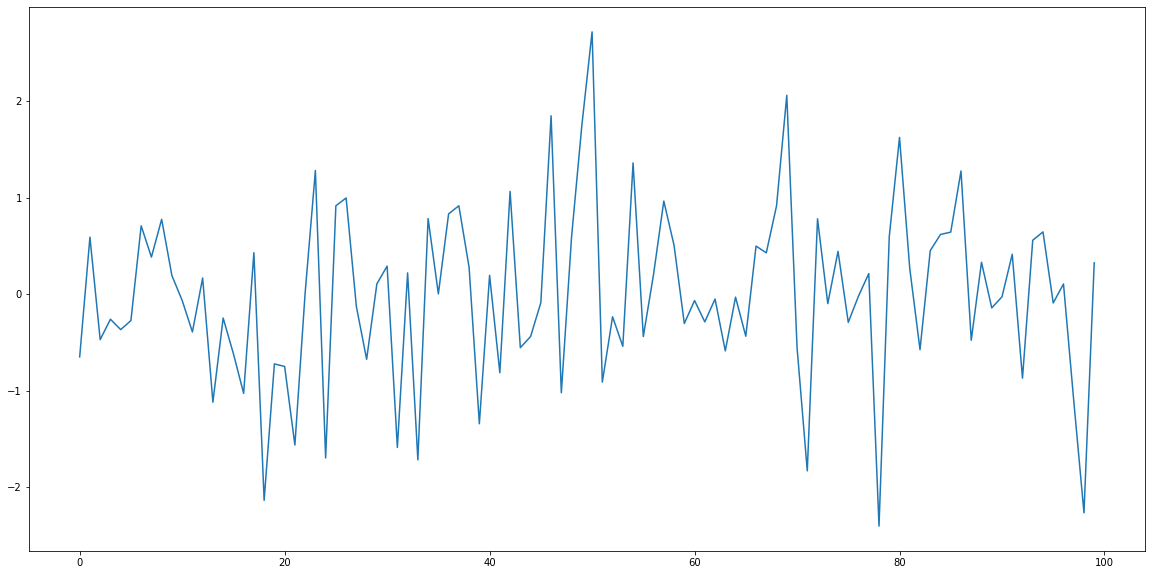

In [34]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,100), sample)
# plt.xticks(data['Adj Close'][::50])
# plt.xticks([])  # Disable xticks.
# plt.ylabel('SPY returns')
# plt.xlabel('Date')